# Problems: 
Predicting user adoption with 2 years worth of data (data format type is csv; there are two files)

# Approach: 
Define User Adoption: A user who has logged into the product on three separate days in at least one seven day period. A column called "adopted?" will be created as the target variable for machine learning.

Clean Data: check for missing values; create datetime columns

Predictive Model: transform categorial variables into dummy variables for machine learning; standardize all continuous columns; several model were checked such as Logistic Regression and Random Forest; coefficients, permutation importance, and shap plots were used to examine feature importance.

Model validity: model was split into a train and validation set. The train set was grid-searched and cross-validated (n_folds = 5) and optimized using f1 because we were dealing with imbalanced data - f1 does not use true negative counts in it's calculations which is perfect for imbalanced data where true negatives are the majority. The cross-validated f1 score on the training set was 88%; The accuracy score was 97% (the baseline for accuracy was 86%, i.e., this model performed 10% better than chance).

# Result:
The f1 score was 89%. The accuracy on the hold-out set was 97%. 

Factors that greatly predict user adoption with high confidence: the year/month for (last_session_)creation_time. That is, when year and month were more recent for "last_session_creation_time", the MORE likely the user was to adopt. When year and month were more recent for "creation_time", the LESS likely the user was to adopt.

### creation_time (negatively correlated with adoption): 
        when account was created
### last_session_creation_time (positively correlated with adoption)): 
        last login

In [1]:
# required if not installed
#!pip install eli5
#!pip install shap
#!pip install --upgrade pandas

In [2]:
# for data manipulation
import pandas as pd
import numpy as np
import os
import json
from collections import Counter
from datetime import datetime, timedelta

# For graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
from IPython.display import display, HTML, Image
import shap

# Packages for ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import eli5
from eli5.sklearn import PermutationImportance

# silence warnings
import warnings
warnings.filterwarnings('ignore')

# A column called "adopted?" will be created as the target variable for machine learning.

In [3]:
path = os.path.abspath('takehome_user_engagement.csv')
eng = pd.read_csv(path)

In [4]:
eng.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [5]:
eng["time"] = pd.to_datetime(eng.time_stamp, infer_datetime_format=True)

In [6]:
eng.head(3)

,time_stamp,user_id,visited,time
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04
2,2013-11-29 03:45:04,2,1,2013-11-29 03:45:04


In [7]:
eng.tail(3)

,time_stamp,user_id,visited,time
207914,2014-04-27 12:45:16,11998,1,2014-04-27 12:45:16
207915,2012-06-02 11:55:59,11999,1,2012-06-02 11:55:59
207916,2014-01-26 08:57:12,12000,1,2014-01-26 08:57:12


In [8]:
eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 4 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
time          207917 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.3+ MB


In [9]:
eng.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [10]:
eng.user_id.value_counts()[:10]

3623    606
906     600
1811    593
7590    590
8068    585
9402    581
4022    580
3269    566
9312    547
7210    545
Name: user_id, dtype: int64

# does not appear to contain missing data

In [11]:
en = eng.copy()

In [12]:
# removing hour/min/sec and non-datetime column
en["time"] = en['time'].dt.normalize()
en = en.drop(["time_stamp"], axis = 1)
en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
time       207917 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [13]:
en.head(3)

,user_id,visited,time
0,1,1,2014-04-22
1,2,1,2013-11-15
2,2,1,2013-11-29


In [14]:
# checking for duplicates
en[en.duplicated()==True]

,user_id,visited,time


In [15]:
en = en.groupby("user_id").rolling(window = "7d", min_periods = 1, on = "time").sum()

In [16]:
en.head(10)

user_id  visited       time
user_id                               
1       0      1.0      1.0 2014-04-22
2       1      2.0      1.0 2013-11-15
        2      2.0      1.0 2013-11-29
        3      2.0      1.0 2013-12-09
        4      2.0      1.0 2013-12-25
        5      4.0      2.0 2013-12-31
        6      2.0      1.0 2014-01-08
        7      2.0      1.0 2014-02-03
        8      4.0      2.0 2014-02-08
        9      6.0      3.0 2014-02-09

In [17]:
en[en.visited >= 3]

user_id  visited       time
user_id                                    
2       9           6.0      3.0 2014-02-09
        10          6.0      3.0 2014-02-13
10      27         30.0      3.0 2013-02-19
        30         30.0      3.0 2013-03-02
        31         30.0      3.0 2013-03-05
...                 ...      ...        ...
11988   207898  71928.0      6.0 2014-05-23
        207899  71928.0      6.0 2014-05-24
        207900  59940.0      5.0 2014-05-26
        207901  59940.0      5.0 2014-05-27
        207902  35964.0      3.0 2014-06-01

[160522 rows x 3 columns]

In [18]:
# get the index for User Adoption 
# (logged into the product on three separate days in at least one seven day period)
adopted = pd.DataFrame(en[en.visited >= 3].index.get_level_values(0))
adopted.head(3)

,user_id
0,2
1,2
2,10


In [19]:
# remove duplicates
adopted = adopted.drop_duplicates()
adopted.head(3)

,user_id
0,2
2,10
257,20


In [20]:
# add target column for machine learning
adopted["adopted?"] = 1
adopted.head(3)

,user_id,adopted?
0,2,1
2,10,1
257,20,1


# Target variable for machine learning has been created
# Next, join with user data

In [21]:
# couldn't read with default engine because of a unicode issue at line 11
path = os.path.abspath('takehome_users.csv')
user = pd.read_csv(path, engine = "python")

In [22]:
# checking why I had to switch to the python engine
user.name[11]

'Mathiesen L�rke'

In [23]:
user.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [24]:
merged = user.merge(adopted, left_on = "object_id" , right_on = "user_id", how = "outer")

In [25]:
merged = merged.drop("user_id", axis = 1)

In [26]:
merged.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted?
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,NaN
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1.0


# Data description

#### name: 
        the user's name
#### object_id: 
        the user's id
#### email: 
        email address
#### creation_source: 
        how their account was created. This takes on one of 5 values:
        ○ PERSONAL_PROJECTS: invited to join another user's personal workspace

        ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)

        ○ ORG_INVITE: invited to an organization (as a full member)

        ○ SIGNUP: signed up via the website

        ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (Google email account as login id)
#### creation_time: 
        when they created their account
#### last_session_creation_time: 
        unix timestamp of last login
#### opted_in_to_mailing_list: 
        whether they have opted into receiving marketing emails
#### enabled_for_marketing_drip: 
        whether they are on the regular marketing email drip
#### org_id: 
        the organization (group of users) they belong to
#### invited_by_user_id: 
        which user invited them to join (if applicable).
#### adopted?: 
        logged into the product on three separate days in at least one seven day period

In [27]:
# checking for missing data
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted?                      1602 non-null float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


In [28]:
merged.creation_time.min(), merged.creation_time.max()

('2012-05-31 00:43:27', '2014-05-30 23:59:19')

# missing about half the data for invited_by_user_id and last_session_creation_time; replacing with 0 should be sufficient as this data is probably missing by design (i.e., users were not invited and users do not have a last session)
# "adopted?" has NaN values by design; therefore, will be replaced with 0

In [29]:
merged = merged.fillna(0)

In [30]:
merged["last_session_creation_time"] = merged["last_session_creation_time"].apply(
    lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))

In [31]:
merged.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted?
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1970-01-01 00:00:00,1,1,74,0.0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,1970-01-01 00:00:00,0,0,302,0.0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,1.0


In [32]:
# sanity check
merged.last_session_creation_time.min(), merged.last_session_creation_time.max()

('1970-01-01 00:00:00', '2014-06-06 14:58:50')

In [33]:
# the emails are too unique; split by domain for machine learning
merged['domain'] = merged['email'].str.split('@').str[1]

In [34]:
merged.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted?,domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,gustr.com


In [35]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted?                      12000 non-null float64
domain                        12000 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 1.2+ MB


# org_id is being recognized as a int, but this is a categorical value and therefore should be a string and then dummy variabled later on

In [36]:
merged.org_id = merged.org_id.astype(str)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null object
invited_by_user_id            12000 non-null float64
adopted?                      12000 non-null float64
domain                        12000 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 1.2+ MB


# all the dates are too unique to be meaningful for ml algorithms, therefore splitting them is necessary

In [37]:
merged["creat_time_"] = pd.to_datetime(merged.creation_time, infer_datetime_format=True)

In [38]:
# making sure inferred dates match original dates
merged.creat_time_.head(3)

0   2014-04-22 03:53:30
1   2013-11-15 03:45:04
2   2013-03-19 23:14:52
Name: creat_time_, dtype: datetime64[ns]

In [39]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null object
invited_by_user_id            12000 non-null float64
adopted?                      12000 non-null float64
domain                        12000 non-null object
creat_time_                   12000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 1.3+ MB


In [40]:
merged["creat_time_year"] = merged.creat_time_.dt.year
merged["creat_time_month"] = merged.creat_time_.dt.month
merged["creat_time_day"] = merged.creat_time_.dt.day

In [41]:
merged.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted?,domain,creat_time_,creat_time_year,creat_time_month,creat_time_day
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,yahoo.com,2014-04-22 03:53:30,2014,4,22
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,gustr.com,2013-11-15 03:45:04,2013,11,15


In [42]:
merged["last_sess_creat_time_"] = pd.to_datetime(merged.last_session_creation_time, infer_datetime_format=True)

In [43]:
# making sure inferred dates match original dates
merged.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted?,domain,creat_time_,creat_time_year,creat_time_month,creat_time_day,last_sess_creat_time_
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,yahoo.com,2014-04-22 03:53:30,2014,4,22,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,gustr.com,2013-11-15 03:45:04,2013,11,15,2014-03-31 03:45:04


In [44]:
merged["last_sess_creat_time_year"] = merged.last_sess_creat_time_.dt.year
merged["last_sess_creat_time_month"] = merged.last_sess_creat_time_.dt.month
merged["last_sess_creat_time_day"] = merged.last_sess_creat_time_.dt.day

In [45]:
merged.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted?,domain,creat_time_,creat_time_year,creat_time_month,creat_time_day,last_sess_creat_time_,last_sess_creat_time_year,last_sess_creat_time_month,last_sess_creat_time_day
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,yahoo.com,2014-04-22 03:53:30,2014,4,22,2014-04-22 03:53:30,2014,4,22
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,gustr.com,2013-11-15 03:45:04,2013,11,15,2014-03-31 03:45:04,2014,3,31


In [46]:
# checking how many unique values in column below
merged.invited_by_user_id.value_counts().iloc[:20]

0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
11770.0      11
4612.0       10
7012.0       10
10481.0      10
4803.0       10
6370.0       10
4302.0       10
8068.0       10
1175.0       10
2354.0       10
10628.0      10
2922.0        9
8426.0        9
6645.0        9
9023.0        9
Name: invited_by_user_id, dtype: int64

In [47]:
# invited_by_user_id has too many unique values;
# generating an invited or not column
merged["invited?"] = (merged.invited_by_user_id > 0) * 1

In [48]:
# sanity check
merged["invited?"].value_counts()[1], (merged.invited_by_user_id > 0).value_counts()[1]

(6417, 6417)

In [49]:
# checking how many unique values in column below
merged.domain.value_counts()[:10]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
mumdc.com            2
dqwln.com            2
oqpze.com            2
qgjbc.com            2
Name: domain, dtype: int64

# domain also has too many unique values, but there are primarily 6 and then "other"

In [50]:
top_emails = list(merged.domain.value_counts()[:6].index)

merged.loc[~merged["domain"].isin(top_emails), "domain"] = "Other"

In [51]:
merged.domain.value_counts()[:10]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
Other             1186
gustr.com         1179
hotmail.com       1165
Name: domain, dtype: int64

In [52]:
# checking how many unique values in column below
merged.org_id.value_counts()[:15]

0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
8      97
14     87
11     75
12     75
17     74
Name: org_id, dtype: int64

In [53]:
# to see df in full
pd.set_option('display.max_columns', 200) 

merged.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted?,domain,creat_time_,creat_time_year,creat_time_month,creat_time_day,last_sess_creat_time_,last_sess_creat_time_year,last_sess_creat_time_month,last_sess_creat_time_day,invited?
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,yahoo.com,2014-04-22 03:53:30,2014,4,22,2014-04-22 03:53:30,2014,4,22,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,gustr.com,2013-11-15 03:45:04,2013,11,15,2014-03-31 03:45:04,2014,3,31,1


In [54]:
# reorganize (categorical, then continuous) and remove unneeded columns from final df for using iloc later

final_df = merged[["creation_source", #categorical
                    "domain",
                    "org_id",
                    "creat_time_year", #continuous
                    "creat_time_month",
                    "creat_time_day",
                    "last_sess_creat_time_year",
                    "last_sess_creat_time_month",
                    "last_sess_creat_time_day",
                    "opted_in_to_mailing_list", # bool
                    "enabled_for_marketing_drip",
                    "invited?",
                    "adopted?" # target for ml
                   ]]

In [55]:
final_df.head(2)         

,creation_source,domain,org_id,creat_time_year,creat_time_month,creat_time_day,last_sess_creat_time_year,last_sess_creat_time_month,last_sess_creat_time_day,opted_in_to_mailing_list,enabled_for_marketing_drip,invited?,adopted?
0,GUEST_INVITE,yahoo.com,11,2014,4,22,2014,4,22,1,0,1,0.0
1,ORG_INVITE,gustr.com,1,2013,11,15,2014,3,31,0,0,1,1.0


In [56]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
creation_source               12000 non-null object
domain                        12000 non-null object
org_id                        12000 non-null object
creat_time_year               12000 non-null int64
creat_time_month              12000 non-null int64
creat_time_day                12000 non-null int64
last_sess_creat_time_year     12000 non-null int64
last_sess_creat_time_month    12000 non-null int64
last_sess_creat_time_day      12000 non-null int64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
invited?                      12000 non-null int64
adopted?                      12000 non-null float64
dtypes: float64(1), int64(9), object(3)
memory usage: 1.3+ MB


In [57]:
# for consistency
final_df["adopted?"] = final_df["adopted?"].astype(int)

In [58]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
creation_source               12000 non-null object
domain                        12000 non-null object
org_id                        12000 non-null object
creat_time_year               12000 non-null int64
creat_time_month              12000 non-null int64
creat_time_day                12000 non-null int64
last_sess_creat_time_year     12000 non-null int64
last_sess_creat_time_month    12000 non-null int64
last_sess_creat_time_day      12000 non-null int64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
invited?                      12000 non-null int64
adopted?                      12000 non-null int64
dtypes: int64(10), object(3)
memory usage: 1.3+ MB


In [59]:
print("fraction of users adopted:", round(len(final_df[final_df["adopted?"] == True])/len(final_df),2))

fraction of users adopted: 0.13


# 13% of users are retained. This percent also reveals that the data is imbalanced; therefore downsampling and/or using F1-score as the metric for validation will be necessary

# visualizations

In [60]:
# For Aesthetics
font = {'size' : 24}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (12.0, 6.0) ### (→ , ↑) ###

In [61]:
def count_plot(column):
    ax = sns.countplot(y = final_df[column], 
                  edgecolor = "black", 
                  linewidth = 4, 
                  order = final_df[column].value_counts().index)
    ax.set(xlabel="Count", 
           ylabel=column.capitalize())
    plt.title(column.capitalize() + " Count")
    plt.show()

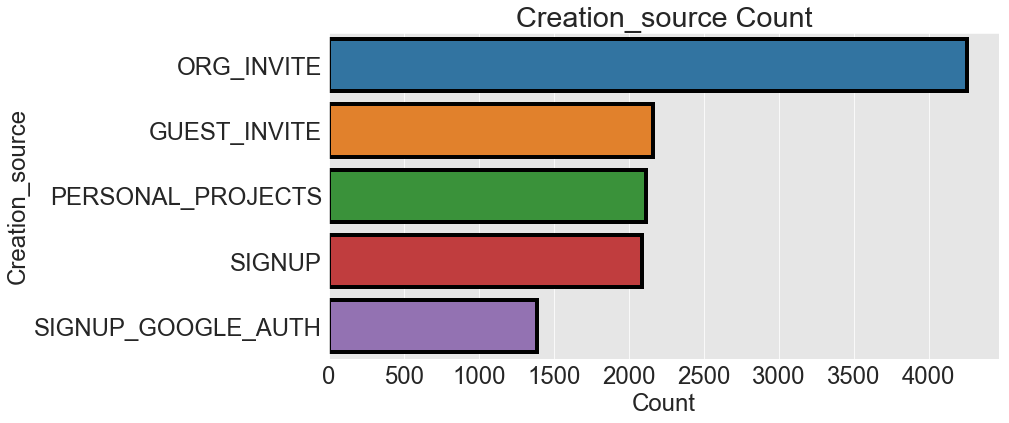

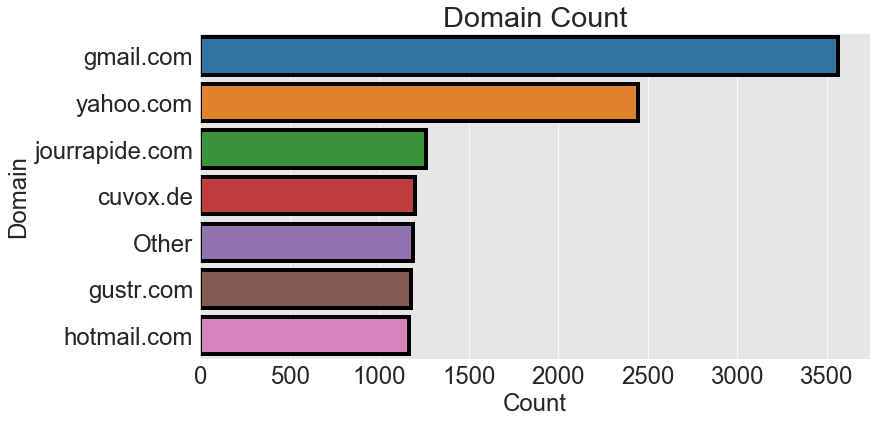

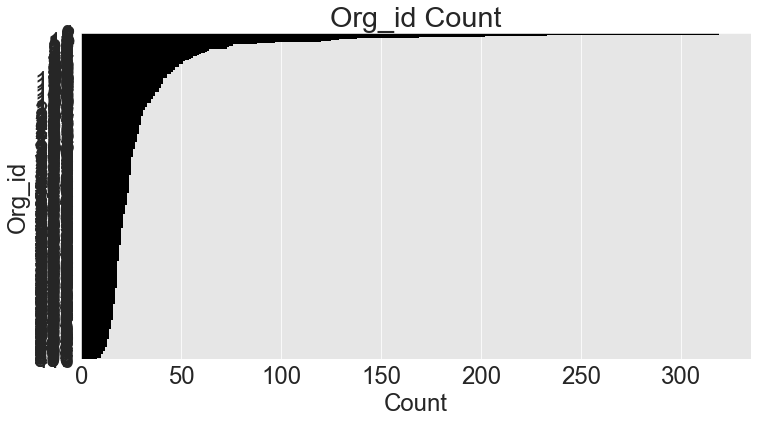

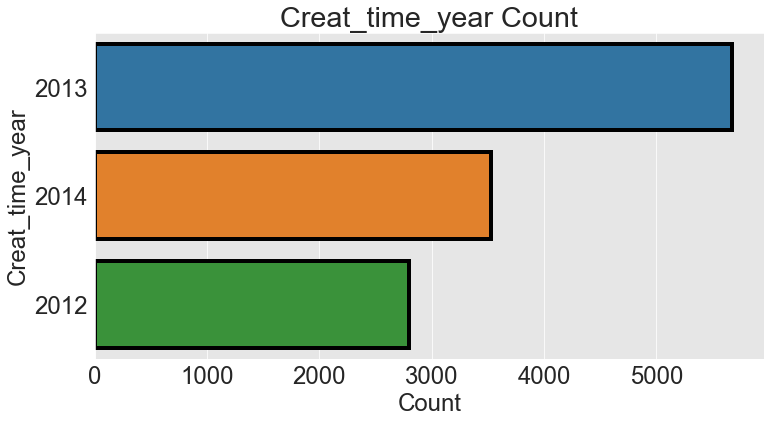

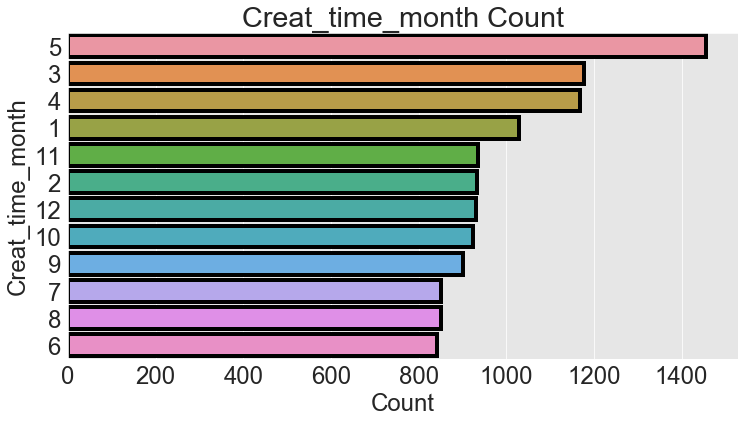

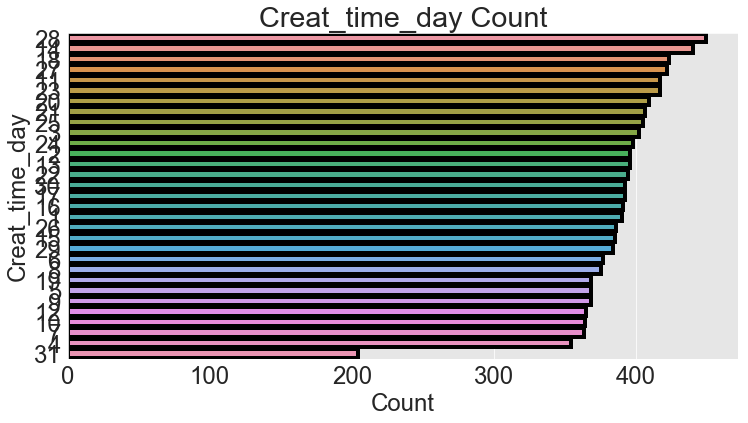

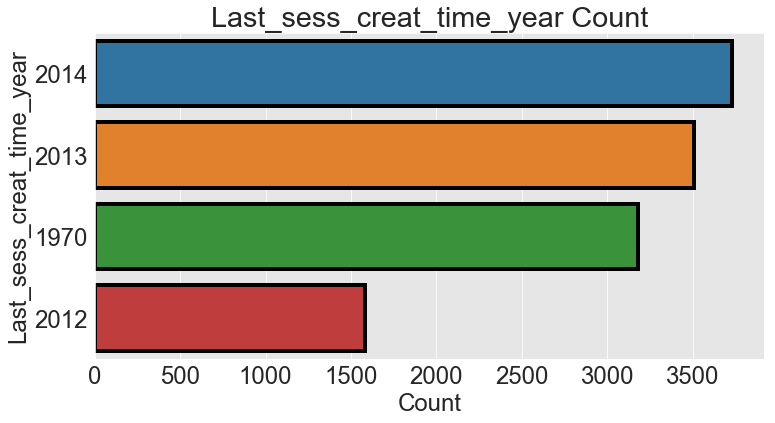

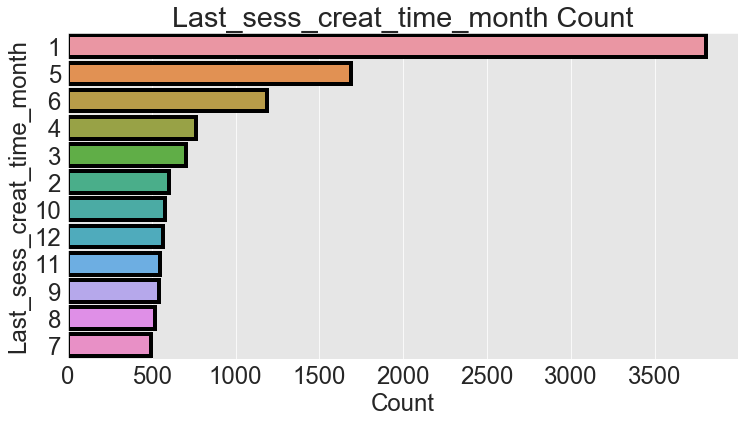

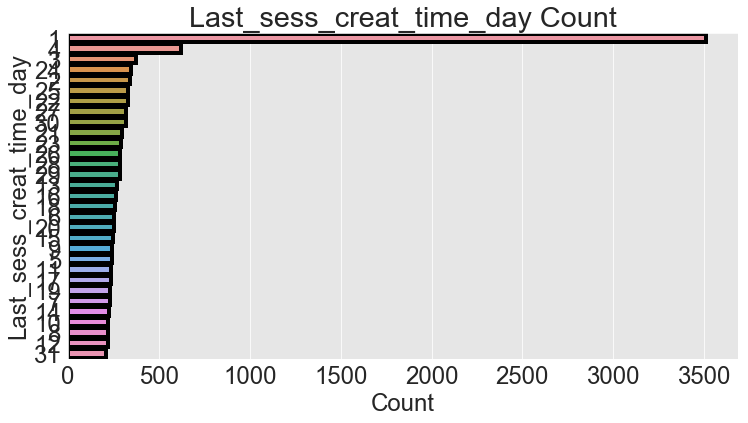

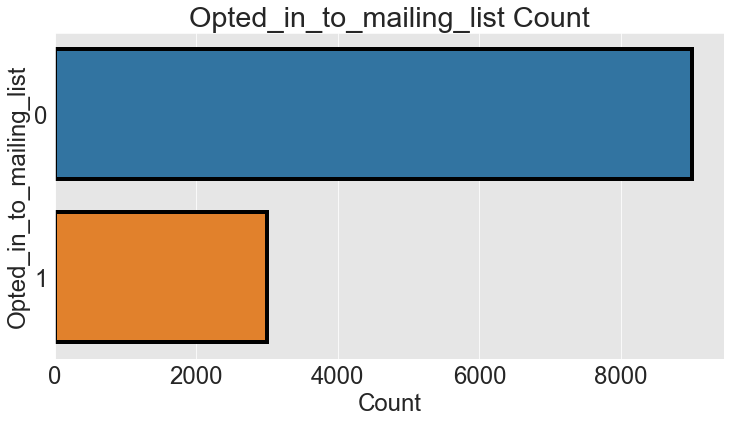

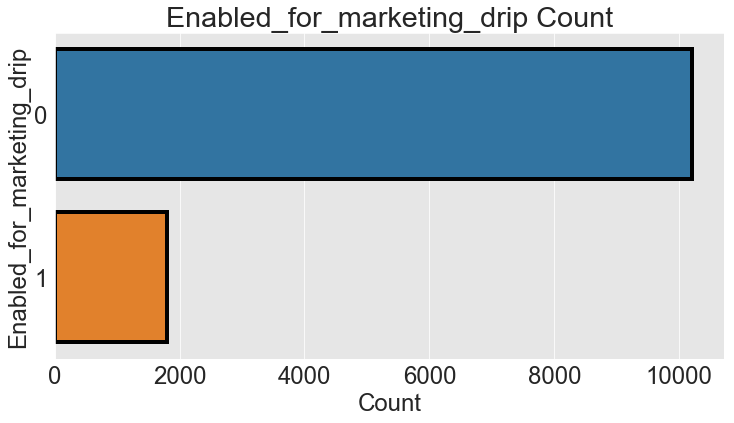

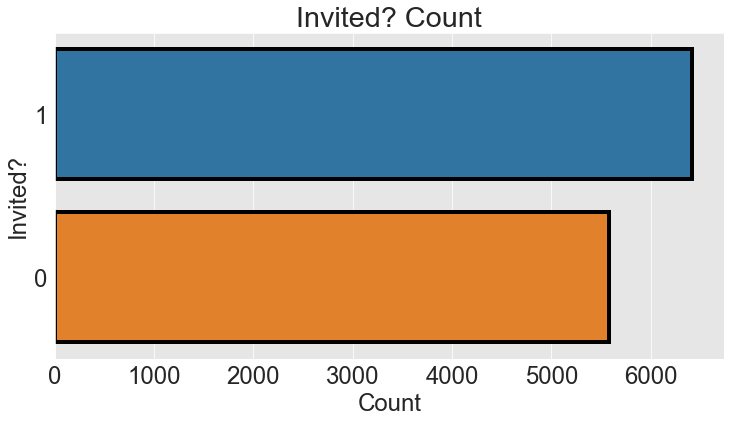

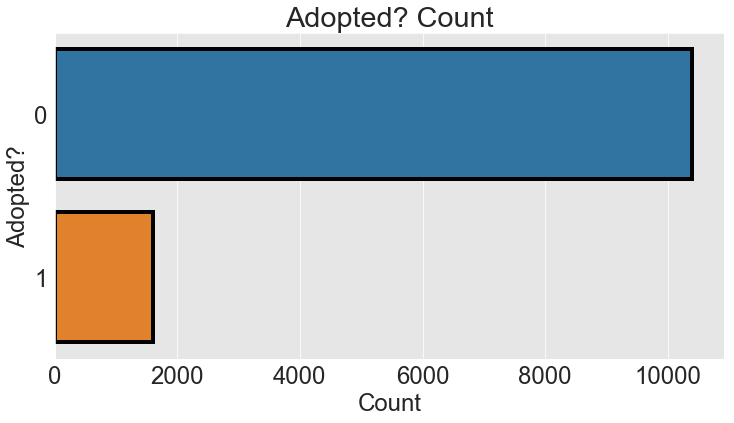

In [62]:
for c in final_df.columns:
    count_plot(c)

# I had not checked how many org_ids there are - far too many to turn this into dummy variables. This will be returned to its pseudo-continuous state

In [63]:
final_df.org_id = final_df.org_id.astype(int)

In [64]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
creation_source               12000 non-null object
domain                        12000 non-null object
org_id                        12000 non-null int64
creat_time_year               12000 non-null int64
creat_time_month              12000 non-null int64
creat_time_day                12000 non-null int64
last_sess_creat_time_year     12000 non-null int64
last_sess_creat_time_month    12000 non-null int64
last_sess_creat_time_day      12000 non-null int64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
invited?                      12000 non-null int64
adopted?                      12000 non-null int64
dtypes: int64(11), object(2)
memory usage: 1.6+ MB


# visualize continuous features

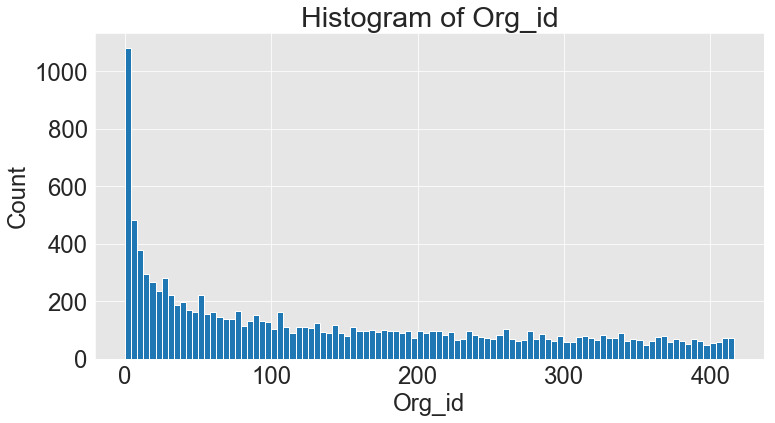

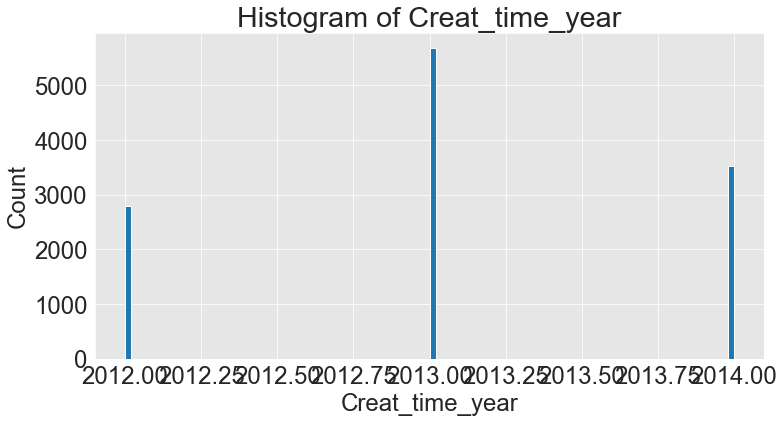

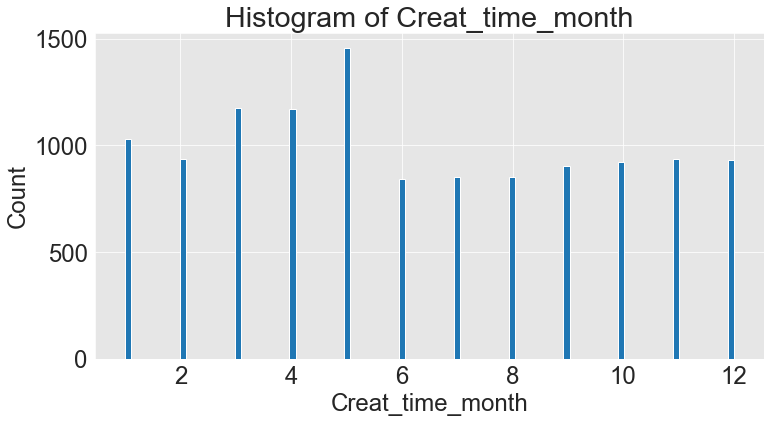

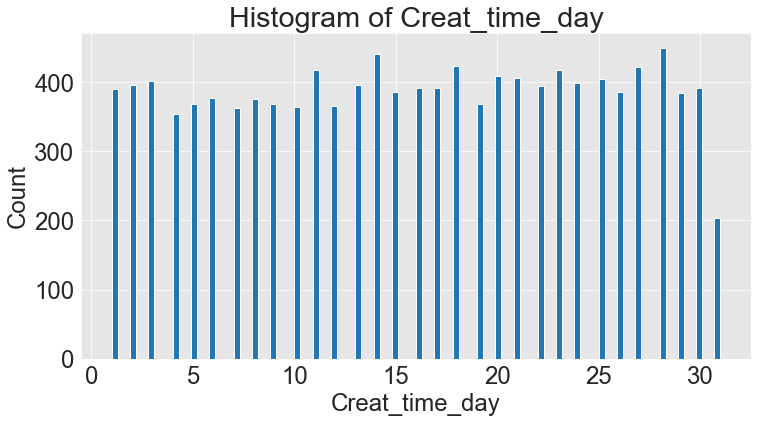

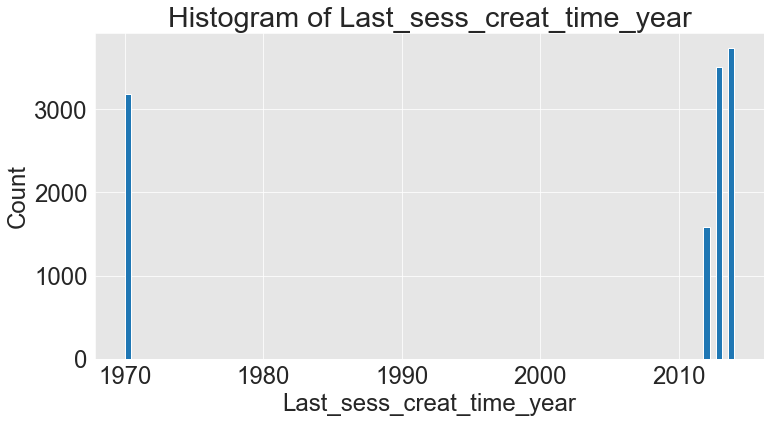

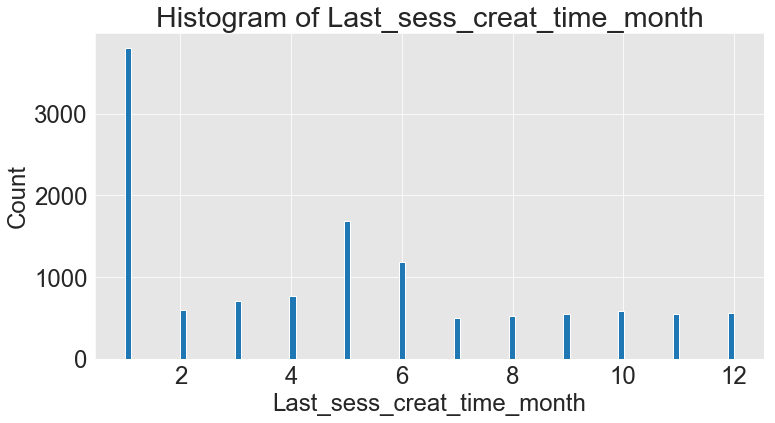

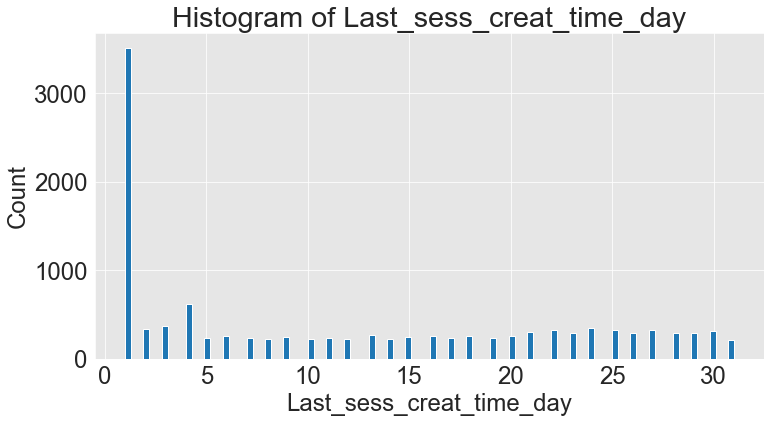

In [65]:
for column in final_df.columns[2:9]:
    final_df.hist(column, bins = 100)
    plt.title("Histogram of " + column.capitalize())
    plt.xlabel(column.capitalize())
    plt.ylabel("Count")
    plt.show()

# I had not considered that using 0 for the missing dates in last_sess_creat_time_day would cause such massive spikes on the first month and first day; this is misleading

In [66]:
final_df.last_sess_creat_time_day[final_df.last_sess_creat_time_year == 1970] = 0
final_df.last_sess_creat_time_month[final_df.last_sess_creat_time_year == 1970] = 0
final_df.last_sess_creat_time_year[final_df.last_sess_creat_time_month == 0] = 0

In [67]:
final_df[final_df.last_sess_creat_time_day == 0].head(2)

,creation_source,domain,org_id,creat_time_year,creat_time_month,creat_time_day,last_sess_creat_time_year,last_sess_creat_time_month,last_sess_creat_time_day,opted_in_to_mailing_list,enabled_for_marketing_drip,invited?,adopted?
7,PERSONAL_PROJECTS,yahoo.com,74,2013,7,31,0,0,0,1,1,0,0
8,PERSONAL_PROJECTS,hotmail.com,302,2013,11,5,0,0,0,0,0,0,0


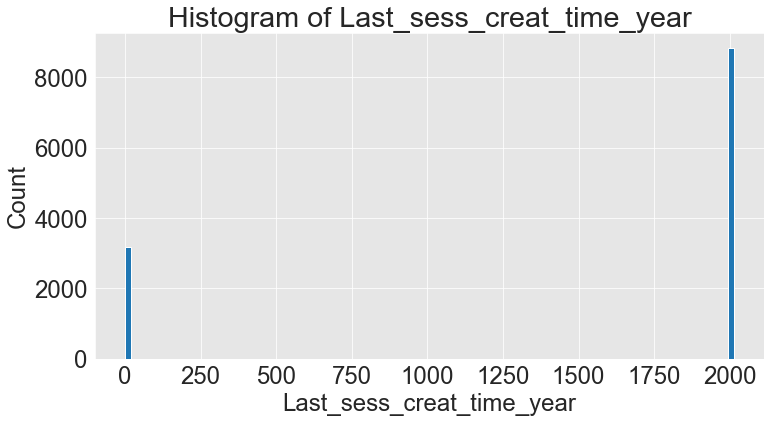

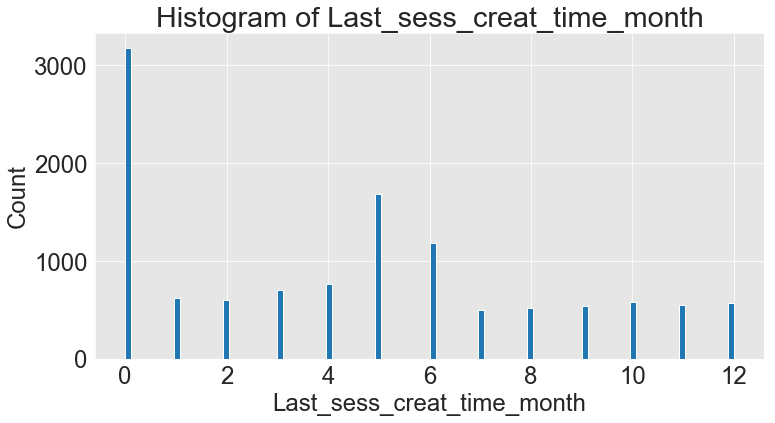

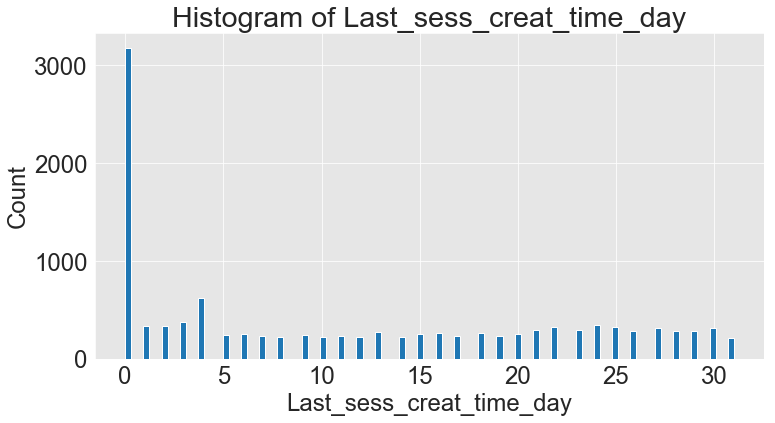

In [68]:
for column in final_df.columns[6:9]:
    final_df.hist(column, bins = 100)
    plt.title("Histogram of " + column.capitalize())
    plt.xlabel(column.capitalize())
    plt.ylabel("Count")
    plt.show()

# Cell below this is a class I created for Binary Classification problems

# Example Use:

### models = Binary_Classification(x, y, standardize = True, scoring = "roc_auc")
takes in x and y, standarizes all continuous columns, performs train_test_split (test_size = 0.3), and performs GridSearchCV on train (n_folds = 5); the metric to evaluate models against will be roc_auc in this case

### models.compare()
will compare several models against one another and compute best parameters for each model

models compared: logistic regression, k-nearest neighbor, gaussian naive bayes, multi nomial naive bayes, random forest, and if desired xtreme gradient boosting (usually takes more than 5 minutes to run so it has been commented out)

### models.test_scores("ran_for", verbose_results = False)
will compute f1, accuracy, and roc_auc score for training and test data using model given (in this case using random forest); verbose_results set to True will generate more details of the results

### models.permutation_importance("ran_for")
will determine which features are most important to the model. "The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled." (https://scikit-learn.org/dev/modules/permutation_importance.html) Permutation importances is computed on the held-out validation set, because "a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit." (same source)

see also: https://www.kaggle.com/dansbecker/permutation-importance

In [69]:
class Binary_Classification:
    def __init__(self, 
                 x, 
                 y, 
                 scoring = None, 
                 test_size = 0.3, 
                 n_folds = 5, 
                 standardize = False): 
        
        self.x = x # features as df
        self.y = y # target as df
        self.scoring = scoring # example: "accuracy", "f1", "roc_auc"
        self.test_size = test_size # set to .3 by default
        self.n_folds = n_folds # set to 5 by default
        self.standardize = standardize
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.x, 
                         self.y, 
                         train_size = self.test_size, 
                         random_state = 0)
    
    """ 
    .examine_model attribute has two functions within it:
    (1) model_and_grid => using a model's name, it returns the model with cvgrid
    (2) best_model => using model_and_grid, finds best hyperparameters for model
    """
    
    def examine_model(self, model_name):
        
        def model_and_grid(model_name):
            if model_name == "log_reg":
                model = LogisticRegression()
                grid = {'C' : [0.001, 0.1, 1, 10, 100]}
                return model, grid

            elif model_name == "knn":
                model = KNeighborsClassifier()
                grid = {"n_neighbors" : [3,6,9,12]}
                return model, grid
            
            elif model_name == "gnb":
                model = GaussianNB()
                grid = {"var_smoothing" : [1e-01, 1e-05, 1e-09, 1e-15]}
                return model, grid
            
            elif model_name == "mnb":
                model = MultinomialNB()
                grid = {"alpha" : [.1, 1, 5, 10, 50]}
                return model, grid
            
            elif model_name == "ran_for":
                model = RandomForestClassifier(random_state=0)
                grid = {'n_estimators' : [1, 30], 
                        'max_features' : ['auto', 'log2'],  
                        'max_depth' : [ 3, 5, 7, 10, 12, 15], 
                        'criterion' : ['gini', 'entropy']}
                return model, grid

            elif model_name == "xgb":
                model = XGBClassifier()
                grid = { 
                          "max_depth"         : [2, 4, 8, 16],
                          "alpha"             : [10, 20, 30],
                          "lambda"            : [10, 20, 30],
        #                  "min_child_weight" : [  1,  5],
        #                  "colsample_bytree" : [ .3, .7],
        #                  "learning_rate"    : [.10, .30],
        #                  "gamma"            : [  0, .5, 5],
        #                  "eta"              : [0.05, 0.20]
                }  
                return model, grid
        
        def best_model(model, grid):
            gs = GridSearchCV(model, param_grid=grid, cv=self.n_folds, scoring=self.scoring)
            gs.fit(self.x_train, self.y_train.iloc[:,0])
            print("CV " + self.scoring.upper() + " SCORE:", round(gs.best_score_,3))
            print("CV PARAMS: ", gs.best_params_)
            #print("BEST MODEL: ", gs.best_estimator_)
            best_model = gs.best_estimator_
            return best_model

        model, grid = model_and_grid(model_name)
        best_mod = best_model(model, grid)
        return best_mod

    """ 
    .compare attribute uses examine_model to compare all models
    """
    
    def compare(self):
        z = 0
        mods = ["log_reg", 
                "knn", 
                "gnb", 
                "mnb", 
                "ran_for",
                #"xgb"
               ]
        for name in mods:
            print("*** " + mods[z] + " ***")
            self.examine_model(name)
            print("")
            z += 1
    
    """ 
    .test_scores attribute uses examine_model to report various metrics on training & test data
    """
    
    def test_scores(self, model_name, verbose_results=False, all_metrics=True, show_test=True): 
        model = self.examine_model(model_name)
        y_pred_train = model.predict(self.x_train)
        y_pred_test = model.predict(self.x_test)
        y_prob_train = model.predict_proba(self.x_train)[:,1]
        y_prob_test = model.predict_proba(self.x_test)[:,1]

        """ F1 (f-one) Score """
        ## F1 Score = 2*((precision*recall)/(precision+recall))
        if self.scoring == "f1" or all_metrics:
            f1_train = metrics.f1_score(self.y_train.iloc[:,0], y_pred_train)
            print("\nF1 on training data:{:0.2f}".format(f1_train))

            if show_test:
                f1_test = metrics.f1_score(self.y_test.iloc[:,0], y_pred_test)
                print("F1 on test data:{:0.2f}".format(f1_test))
                print()

        """ Accuracy """
        ## number of correct predictions made / total number of predictions made
        ### accuracy is not a good metric for imbalanced data
        if self.scoring == "accuracy" or all_metrics:
            accuracy_training = model.score(self.x_train, self.y_train)
            tru_count_train = Counter(self.y_train.iloc[:,0])[True]
            fal_count_train = Counter(self.y_train.iloc[:,0])[False]

            # test baseline
            print("chance of true in training (baseline): ", 
                  round(tru_count_train/(tru_count_train + fal_count_train),2))
            print("chance of false in training (baseline): ", 
                  round(fal_count_train/(tru_count_train + fal_count_train),2))
            
            print("Accuracy on training data: {:0.2f}".format(accuracy_training))
            print()

            if show_test:
                accuracy_test = model.score(self.x_test, self.y_test)
                tru_count_test = Counter(self.y_test.iloc[:,0])[True]
                fal_count_test = Counter(self.y_test.iloc[:,0])[False]

                # test baseline
                print("chance of true in test (baseline): ", 
                      round(tru_count_test/(tru_count_test + fal_count_test),2))
                print("chance of false in test (baseline): ", 
                      round(fal_count_test/(tru_count_test + fal_count_test),2))
                
                print("Accuracy on test data:  {:0.2f}".format(accuracy_test))
                print()

        """ ROC AUC """
        ## How well model distinguishs between classes
        ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
        #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
        if self.scoring == "roc_auc" or all_metrics:
            roc_auc_score_training = roc_auc_score(self.y_train.iloc[:,0], y_prob_train)
            print("ROC AUC on training data:{:0.2f}".format(roc_auc_score_training))

            if show_test:
                roc_auc_score_test = roc_auc_score(self.y_test.iloc[:,0], y_prob_test)
                print("ROC AUC on test data:{:0.2f}\n".format(roc_auc_score_test))

            if not show_test:
                print()

        """ Classification Report """
        ## Precision = TP / TP + FP
        ### Also known as Positive Predictive Value
        ## Recall = TP/ TP + FN
        class_repo = classification_report(self.y_test,y_pred_test)
        print("\nClassification Report on test data:\n", class_repo)

        try:
            # Coefficients
            coefs = pd.Series(model.coef_[0], index=self.x.columns)
            coefs = coefs.sort_values()
            coefs.plot(kind="bar",title="Coefficients")
            #plt.xticks(fontsize=20)
            #plt.yticks(fontsize=20)
            plt.show()
            #print(coefs.sort_values(ascending = False))
        except: 
            print("No coefficients need to be fitted by optimization procedure")
            
        """ Confusion matrix """
        def print_confusion_matrix(confusion_matrix, 
                           class_names,
                           #figsize = (2,2), fontsize=20
                          ):
    
            """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
            2 benefits: (1) mieruka (i.e., visual control) and 
            (2) colors change depending on values (larger values generate darker colors)
            
            if you're wondering what mieruka is: 
            https://harishsnotebook.wordpress.com/2016/05/05/visibilization-crime-fighting-magic-and-mieruka/

            Arguments
            ---------
            confusion_matrix: numpy.ndarray
                The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
                Similarly constructed ndarrays can also be used.
            class_names: list
                An ordered list of class names, in the order they index the given confusion matrix.
            figsize: tuple
                A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
                the second determining the vertical size. Defaults to (10,7).
            fontsize: int
                Font size for axes labels. Defaults to 14.

            Returns
            -------
            matplotlib.figure.Figure
                The resulting confusion matrix figure
            """

            df_cm = pd.DataFrame(
                confusion_matrix, 
                index=class_names, 
                columns=class_names, 
            )

            fig = plt.figure(#figsize=figsize
            )

            try:
                heatmap = sns.heatmap(df_cm, 
                                      annot=True, 
                                      fmt="d", 
                                      cbar=False, 
                                      cmap="YlGnBu")
            except ValueError:
                raise ValueError("Confusion matrix values must be integers.")

                heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                                             rotation=0, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

                heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                                             rotation=45, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

            plt.title('Confusion Matrix')
            plt.ylabel('Correct label')
            plt.xlabel('Predicted label')
            
        c_matrix = confusion_matrix(self.y_test, y_pred_test)
        print_confusion_matrix(c_matrix, [False, True])
        
        if verbose_results:
            #Plot ROC curve
            fpr, tpr, thresholds = roc_curve(self.y_test, y_prob_test)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            print("")    
                
            # Threshold Plot
            precision, recall, thresholds = precision_recall_curve(self.y_test, y_prob_test)
            f1 = []
            acc = []
            roc = []
            avg_pr = []

            def adjust_pred_prob(y_prob_test, new_threshold):
                return [1 if prob >= new_threshold else 0 for prob in y_prob_test]

            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_f1 = metrics.f1_score(self.y_test, adjusted_y_pred)
                f1.append(add_f1)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_acc = accuracy_score(self.y_test, adjusted_y_pred)
                acc.append(add_acc)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_avg_pr = average_precision_score(self.y_test, adjusted_y_pred)
                avg_pr.append(add_avg_pr)
                
#             ## Retrieve probability of being 1(in second column of probs_y)
#             pr_auc = metrics.auc(recall, precision)

            plt.title("Precision-Recall-Accuracy vs Threshold")
            plt.plot(thresholds, precision[: -1], "b-", label="Precision")
            plt.plot(thresholds, recall[: -1], "r-", label="Recall")
            #plt.plot(thresholds, avg_pr, "k-", label="Average Precision Recall")
            #plt.plot(thresholds, f1, "k-", label="F1_Score")
            plt.plot(thresholds, acc, "g-", label="Accuracy")
            
            max_acc_x = thresholds[np.argmax(acc)]
            plt.axvline(x=max_acc_x, ymin=0.00, ymax=max(acc), color='g', linestyle='-')
            #plt.axhline(y=max(acc), color='g', linestyle='--')
            #plt.text(max_acc_x, max(acc), ("Max Accuracy " + str(round(max_acc_x,2))), rotation=90)
            
            #max_f1_x = thresholds[np.argmax(f1)]
            #plt.axvline(x=max_f1_x, color='k', linestyle='--')
            #plt.axhline(y=max(f1), color='k', linestyle='--')
            #plt.text(max_f1_x, max(f1), ("Max F1 Score " + str(round(max_f1_x,2))), rotation=90)
                        
            plt.ylabel("Score")
            plt.xlabel("Threshold")
            
            #plt.text(intersect_x, intersect_y, 'PR Intersect', rotation=90)
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            print("Maximum Accuracy: " + str(round(max(acc),2)) + " @ Threshold: " + str(round(max_acc_x,2)))
            #print("Maximum F1 Score: " + str(round(max(f1),2)) + " @ Threshold: " + str(round(max_f1_x,2)))
            
            """ 
            Varying Fscore's beta vs Varying Thresholds
            
            The beta parameter determines the weight of recall in the combined score. 
            beta < 1 lends more weight to precision, while 
            beta > 1 favors recall 
            (beta -> 0 considers only precision, beta -> inf only recall).
            """

            f025 = []
            f050 = []
            f075 = []
            f100 = []
            f125 = []
            f150 = []
            f200 = []

            def fbeta_testing(beta, fxxx):
                for t in thresholds:
                    adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                    add_fbeta = metrics.fbeta_score(self.y_test, adjusted_y_pred, beta)
                    fxxx.append(add_fbeta)

            betas = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 2.00]
            flist = [f025, f050, f075, f100, f125, f150, f200]

            z = 0
            for beta in betas:
                fbeta_testing(beta, flist[z])
                z += 1

            plt.title("F_Beta_Score vs Threshold: Varying Betas")
            #plt.plot(thresholds, f025, "r-", label="F0.25")
            plt.plot(thresholds, f050, "m-", label="F0.50")
            #plt.plot(thresholds, f075, "g-", label="F0.75")
            plt.plot(thresholds, f100, "c-", label="F1.00")
            #plt.plot(thresholds, f125, "b-", label="F1.25")
            #plt.plot(thresholds, f150, "k-", label="F1.50")
            plt.plot(thresholds, f200, "y-", label="F2.00")
            #plt.axvline(.425, color='k', linestyle='--')
            #plt.axvline(.45, color='k', linestyle='-')
            
            max_f050_x = thresholds[np.argmax(f050)]
            plt.axvline(x=max_f050_x, ymin=0.00, ymax=max(f050), color='m', linestyle='-')
            max_f100_x = thresholds[np.argmax(f100)]
            plt.axvline(x=max_f100_x,ymin=0.00, ymax=max(f100), color='c', linestyle='-')
            max_f200_x = thresholds[np.argmax(f200)]
            plt.axvline(x=max_f200_x, ymin=0.00, ymax=max(f200), color='y', linestyle='-')
            
            plt.ylabel("F_Beta_Score")
            plt.xlabel("Threshold")
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            
            print("Maximum F0.5 Score: " + str(round(max(f050),2)) + " @ Threshold: " + str(round(max_f050_x,2)))
            print("Maximum F1   Score: " + str(round(max(f100),2)) + " @ Threshold: " + str(round(max_f100_x,2)))
            print("Maximum F2.0 Score: " + str(round(max(f200),2)) + " @ Threshold: " + str(round(max_f200_x,2)))

            """ Threshold = 0.5, varying fscore's beta """

            betas = [0.25,0.50,0.75,1.00,1.25,1.50,2.00]
            fbetas = []

            for beta in betas:
                score = fbeta_score(self.y_test, y_pred_test, beta=beta)
                fbetas.append(score)
        
    def feature_importance(self, model_name): 
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        importances = fitted.feature_importances_
        indices = np.argsort(importances)
        features = self.x_train.columns
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.ylabel('Features')
        plt.show()
    
    """ 
    .permutation_importance attribute uses examine_model to report features in order of importance
    """
    def permutation_importance(self, model_name): 
        # https://www.kaggle.com/dansbecker/permutation-importance
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        perm = PermutationImportance(fitted, random_state=0).fit(self.x_test, self.y_test.iloc[:,0])
        return eli5.show_weights(perm, feature_names = self.x_test.columns.tolist())
    
    def shap_summary_plot(self, model_name): 
        """Calculating SHAP values can be slow"""
        # https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
        
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        if model_name == "ran_for":
            explainer = shap.TreeExplainer(fitted)
            shap_values = explainer.shap_values(self.x_test)
            # we index in ([1]) to get the SHAP values for the prediction of "True"
            return shap.summary_plot(shap_values[1], self.x_test)
        
        else:     
            """ KernelExplainer cannot handle boolean values, they must be converted to int """
            x_train_summary = shap.kmeans(self.x_train, 3)
            explainer = shap.KernelExplainer(fitted.predict, x_train_summary)
            shap_values = explainer.shap_values(self.x_test)
            return shap.summary_plot(shap_values, self.x_test)
    
    def coefficients(self, model_name):
        model = self.examine_model(model_name)
        try:
            # Coefficients
            coefs = pd.Series(model.coef_[0], index = self.x.columns)
            coefs = coefs.sort_values()
            coefs.plot(kind="bar",title=(model_name.capitalize() + " Coefficients"))
            plt.show()
        except: 
            print("No coefficients need to be fitted by optimization procedure")

In [70]:
final_df.head(1)

,creation_source,domain,org_id,creat_time_year,creat_time_month,creat_time_day,last_sess_creat_time_year,last_sess_creat_time_month,last_sess_creat_time_day,opted_in_to_mailing_list,enabled_for_marketing_drip,invited?,adopted?
0,GUEST_INVITE,yahoo.com,11,2014,4,22,2014,4,22,1,0,1,0


In [71]:
# create dummies for categorical variables

dummies = pd.get_dummies(final_df.iloc[:,:2])
other_vars = final_df.iloc[:,2:-1]

x = pd.concat([dummies, other_vars], axis = 1)
y = final_df[['adopted?']] 
# y is kept as a dataframe for the graphics made by my class; it is transformed into a series when called for ML

# check x is correct
x.head(3)

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_Other,domain_cuvox.de,domain_gmail.com,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_yahoo.com,org_id,creat_time_year,creat_time_month,creat_time_day,last_sess_creat_time_year,last_sess_creat_time_month,last_sess_creat_time_day,opted_in_to_mailing_list,enabled_for_marketing_drip,invited?
0,1,0,0,0,0,0,0,0,0,0,0,1,11,2014,4,22,2014,4,22,1,0,1
1,0,1,0,0,0,0,0,0,1,0,0,0,1,2013,11,15,2014,3,31,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,0,94,2013,3,19,2013,3,19,0,0,1


In [72]:
models = Binary_Classification(x, y, standardize = True, scoring = "f1")
# we use f1 as the optimization metric because we were dealing with 
# highly imbalanced data (only 13% true)
# we will use downsampling if the results of this model are poor

models.compare()

*** log_reg ***
CV F1 SCORE: 0.878
CV PARAMS:  {'C': 100}

*** knn ***
CV F1 SCORE: 0.472
CV PARAMS:  {'n_neighbors': 3}

*** gnb ***
CV F1 SCORE: 0.34
CV PARAMS:  {'var_smoothing': 1e-15}

*** mnb ***
CV F1 SCORE: 0.308
CV PARAMS:  {'alpha': 0.1}

*** ran_for ***
CV F1 SCORE: 0.85
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}



CV F1 SCORE: 0.878
CV PARAMS:  {'C': 100}

F1 on training data:0.89
F1 on test data:0.89

chance of true in training (baseline):  0.14
chance of false in training (baseline):  0.86
Accuracy on training data: 0.97

chance of true in test (baseline):  0.13
chance of false in test (baseline):  0.87
Accuracy on test data:  0.97

ROC AUC on training data:0.99
ROC AUC on test data:0.99


Classification Report on test data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7286
           1       0.96      0.83      0.89      1114

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.97      0.91      0.94      8400
weighted avg       0.97      0.97      0.97      8400



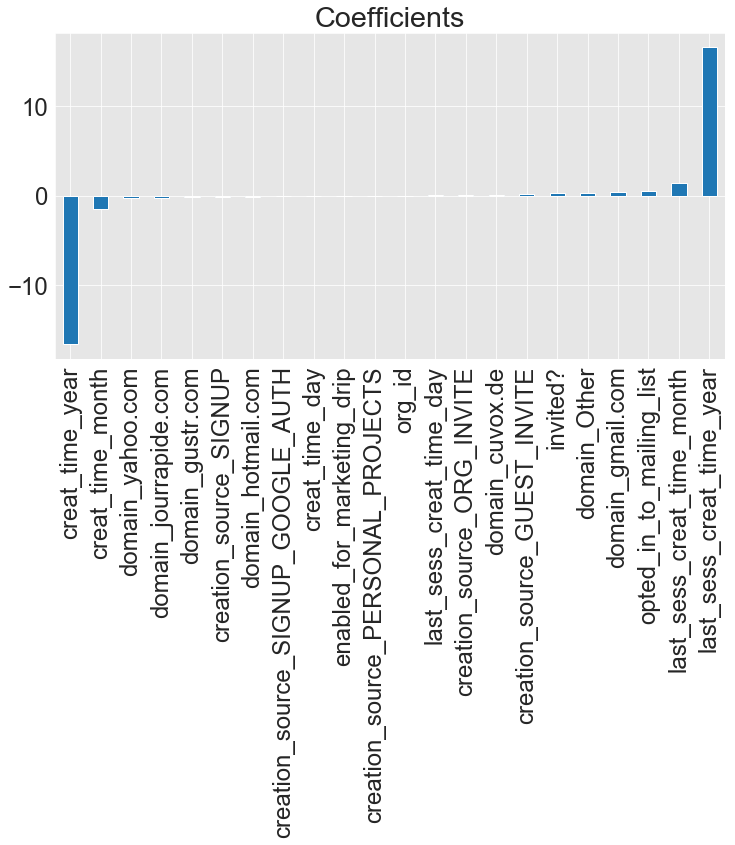

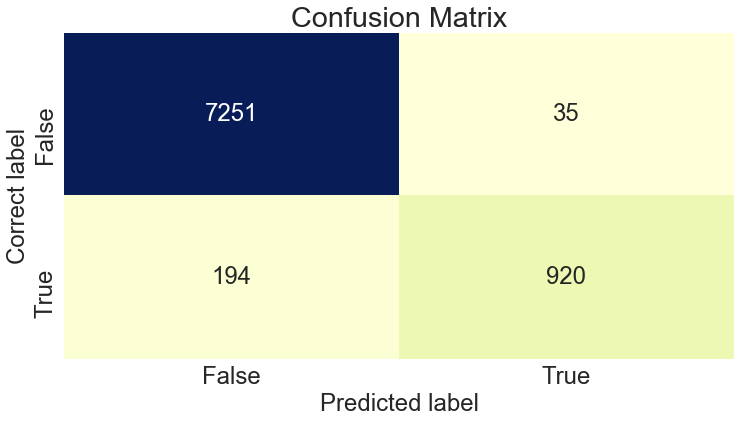

In [73]:
# logistic regression gives the highest cross-validation scores; let's see its ability to generalize
models.test_scores("log_reg")

In [74]:
models.permutation_importance("log_reg")

CV F1 SCORE: 0.878
CV PARAMS:  {'C': 100}


Weight,Feature
0.2665 ± 0.0048,last_sess_creat_time_year
0.2150 ± 0.0035,creat_time_year
0.1759 ± 0.0060,creat_time_month
0.1348 ± 0.0066,last_sess_creat_time_month
0.0005 ± 0.0007,creat_time_day
0.0003 ± 0.0009,last_sess_creat_time_day
0.0002 ± 0.0002,creation_source_PERSONAL_PROJECTS
0.0001 ± 0.0002,domain_jourrapide.com
0.0000 ± 0.0003,domain_Other
0.0000 ± 0.0002,domain_cuvox.de


CV F1 SCORE: 0.878
CV PARAMS:  {'C': 100}


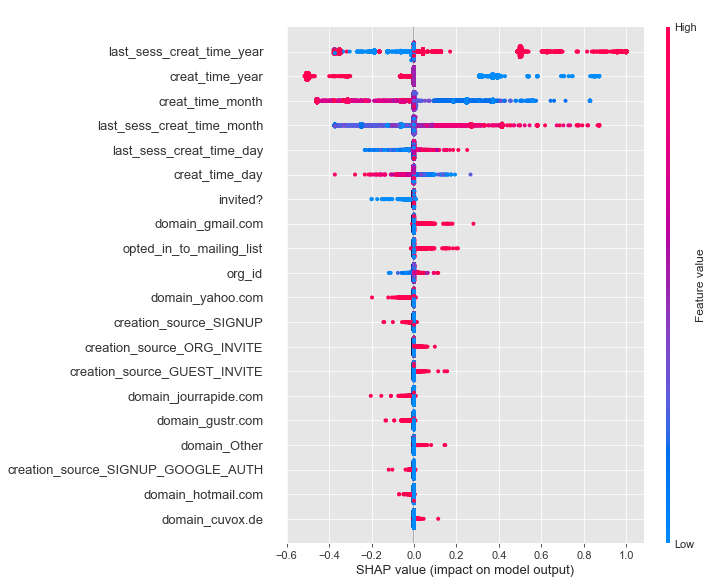

In [75]:
models.shap_summary_plot("log_reg")

# I wonder if any features are highly correlated with the target variable

In [76]:
""" For checking which features are most correlated """

def get_redundant_pairs(df):
    # Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def over_50perc_corr(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    tops = au_corr[au_corr > 0.50] 
    return tops

In [77]:
corr_df = pd.concat([x,y], axis=1)

over_50perc_corr(corr_df)

last_sess_creat_time_year           last_sess_creat_time_month    0.705684
creation_source_ORG_INVITE          invited?                      0.691238
last_sess_creat_time_year           last_sess_creat_time_day      0.653949
creat_time_year                     creat_time_month              0.612594
creation_source_SIGNUP_GOOGLE_AUTH  domain_gmail.com              0.555953
dtype: float64

# some of the features are highly correlated with one another, but none are highly correlated with the target

# since we have highly correlated features and the time features overpowered the other features, let's drop those and see if there are any other predictors of adoption

In [78]:
x2 = x[[cols for cols in x if cols not in ["last_sess_creat_time_year", # dropping highly predictive time features
               "last_sess_creat_time_month", 
               "creat_time_year", 
               "creat_time_month",
               "invited?", # dropping highly correlated features
               "domain_gmail.com"]]]

In [79]:
x2.head(3)

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,domain_Other,domain_cuvox.de,domain_gustr.com,domain_hotmail.com,domain_jourrapide.com,domain_yahoo.com,org_id,creat_time_day,last_sess_creat_time_day,opted_in_to_mailing_list,enabled_for_marketing_drip
0,1,0,0,0,0,0,0,0,0,0,1,11,22,22,1,0
1,0,1,0,0,0,0,0,1,0,0,0,1,15,31,0,0
2,0,1,0,0,0,0,0,1,0,0,0,94,19,19,0,0


In [80]:
models2 = Binary_Classification(x2, y, standardize = True, scoring = "f1")

models2.compare()

*** log_reg ***
CV F1 SCORE: 0.004
CV PARAMS:  {'C': 0.001}

*** knn ***
CV F1 SCORE: 0.29
CV PARAMS:  {'n_neighbors': 3}

*** gnb ***
CV F1 SCORE: 0.077
CV PARAMS:  {'var_smoothing': 1e-09}

*** mnb ***
CV F1 SCORE: 0.36
CV PARAMS:  {'alpha': 5}

*** ran_for ***
CV F1 SCORE: 0.463
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV F1 SCORE: 0.463
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}

F1 on training data:0.92
F1 on test data:0.46

chance of true in training (baseline):  0.14
chance of false in training (baseline):  0.86
Accuracy on training data: 0.98

chance of true in test (baseline):  0.13
chance of false in test (baseline):  0.87
Accuracy on test data:  0.89

ROC AUC on training data:1.00
ROC AUC on test data:0.90


Classification Report on test data:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7286
           1       0.70      0.34      0.46      1114

   micro avg       0.89      0.89      0.89      8400
   macro avg       0.80      0.66      0.70      8400
weighted avg       0.88      0.89      0.88      8400

No coefficients need to be fitted by optimization procedure


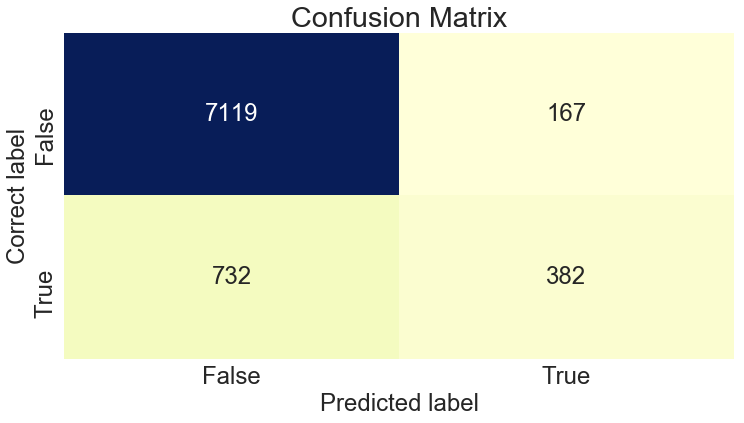

In [81]:
models2.test_scores("ran_for")

# Without the key time features, the model performs no better than chance with low f1 scores.